In [1]:
import os
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("BigDataPractice") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()

print("Spark success!")

data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('employees')

spark.sql('SELECT * FROM employees').show()
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
spark.sql('SELECT AVG(Salary) FROM employees').show()


25/10/28 10:09:20 WARN Utils: Your hostname, rayfal resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/10/28 10:09:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/28 10:09:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark success!


+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
| Anna| 28|     F|  4100|     2|
|  Lee| 23|     M|  2700|     1|
+-----+---+------+------+------+



+----+---+
|Name|Age|
+----+---+
|Anna| 28|
+----+---+



+------------------+
|       avg(Salary)|
+------------------+
|3266.6666666666665|
+------------------+



In [6]:
spark.sql('''
SELECT Gender, SUM(Salary) as TotalSalary, Age
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()

[Stage 14:>                                                         (0 + 3) / 3]

+------+-----------+---+
|Gender|TotalSalary|Age|
+------+-----------+---+
|     M|       2700| 23|
|     F|       4100| 28|
|     M|       3000| 34|
+------+-----------+---+



In [5]:
spark.sql('''
SELECT DeptId, AVG(Salary) AS AvgSalary
FROM employees
GROUP BY DeptId
ORDER BY AvgSalary DESC
''').show()

[Stage 7:=======================================>                   (2 + 1) / 3]

+------+---------+
|DeptId|AvgSalary|
+------+---------+
|     2|   4100.0|
|     1|   2850.0|
+------+---------+



In [8]:
spark.sql('''
WITH avg_gender AS (
SELECT Gender, AVG(Salary) AS AvgSalary
FROM employees
GROUP BY Gender
)
SELECT e.Name, e.Gender, e.Salary, g.AvgSalary
FROM employees e
JOIN avg_gender g
ON e.Gender = g.Gender
WHERE e.Salary > g.AvgSalary
ORDER BY e.Salary DESC
''').show()

[Stage 19:===================>                                      (1 + 2) / 3]

+-----+------+------+---------+
| Name|Gender|Salary|AvgSalary|
+-----+------+------+---------+
|James|     M|  3000|   2850.0|
+-----+------+------+---------+



In [7]:
spark.sql('''
SELECT 
Name,
DeptId,
Salary,
RANK() OVER (PARTITION BY DeptId ORDER BY Salary DESC) AS RankInDept
FROM employees
ORDER BY DeptId, RankInDept
''').show()

[Stage 15:======================================>                   (2 + 1) / 3]

+-----+------+------+----------+
| Name|DeptId|Salary|RankInDept|
+-----+------+------+----------+
|James|     1|  3000|         1|
|  Lee|     1|  2700|         2|
| Anna|     2|  4100|         1|
+-----+------+------+----------+



In [9]:
spark.sql('''
SELECT Name, Age, Salary, ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) as rank
FROM employees
''').show()

[Stage 23:==========================================================(3 + 0) / 3]

+-----+---+------+----+
| Name|Age|Salary|rank|
+-----+---+------+----+
|  Lee| 23|  2700|   1|
| Anna| 28|  4100|   1|
|James| 34|  3000|   1|
+-----+---+------+----+



In [10]:
spark.sql('''
SELECT 
Name, DeptId, Salary,
RANK() OVER (PARTITION BY DeptId ORDER BY Salary DESC) AS RankInDept
FROM employees
''').show()

[Stage 26:>                                                         (0 + 3) / 3]

+-----+------+------+----------+
| Name|DeptId|Salary|RankInDept|
+-----+------+------+----------+
|James|     1|  3000|         1|
|  Lee|     1|  2700|         2|
| Anna|     2|  4100|         1|
+-----+------+------+----------+



In [11]:
spark.sql('''
SELECT Name, Age, Salary, ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) as rank
FROM employees
''').show()

+-----+---+------+----+
| Name|Age|Salary|rank|
+-----+---+------+----+
|  Lee| 23|  2700|   1|
| Anna| 28|  4100|   1|
|James| 34|  3000|   1|
+-----+---+------+----+



In [2]:
spark.sql('''
SELECT 
d.DeptName,
e.Name,
e.Salary,
AVG(e.Salary) OVER (PARTITION BY d.DeptName) AS AvgSalaryPerDept,
RANK() OVER (PARTITION BY d.DeptName ORDER BY e.Salary DESC) AS RankInDept
FROM employees e
JOIN departments d 
ON e.DeptId = d.DeptId
ORDER BY d.DeptName, RankInDept
''').show()

[Stage 9:===========================================================(3 + 0) / 3]

+---------+-----+------+----------------+----------+
| DeptName| Name|Salary|AvgSalaryPerDept|RankInDept|
+---------+-----+------+----------------+----------+
|       HR|James|  3000|          2850.0|         1|
|       HR|  Lee|  2700|          2850.0|         2|
|Marketing| Anna|  4100|          4100.0|         1|
+---------+-----+------+----------------+----------+



In [3]:
spark.sql('''
SELECT 
d.DeptName,
e.Name,
e.Age,
e.Salary,
LAG(e.Salary) OVER (PARTITION BY d.DeptName ORDER BY e.Age) AS PrevSalary,
(e.Salary - LAG(e.Salary) OVER (PARTITION BY d.DeptName ORDER BY e.Age)) AS SalaryTrend
FROM employees e
JOIN departments d
ON e.DeptId = d.DeptId
ORDER BY d.DeptName, e.Age
''').show()


+---------+-----+---+------+----------+-----------+
| DeptName| Name|Age|Salary|PrevSalary|SalaryTrend|
+---------+-----+---+------+----------+-----------+
|       HR|  Lee| 23|  2700|      NULL|       NULL|
|       HR|James| 34|  3000|      2700|        300|
|Marketing| Anna| 28|  4100|      NULL|       NULL|
+---------+-----+---+------+----------+-----------+



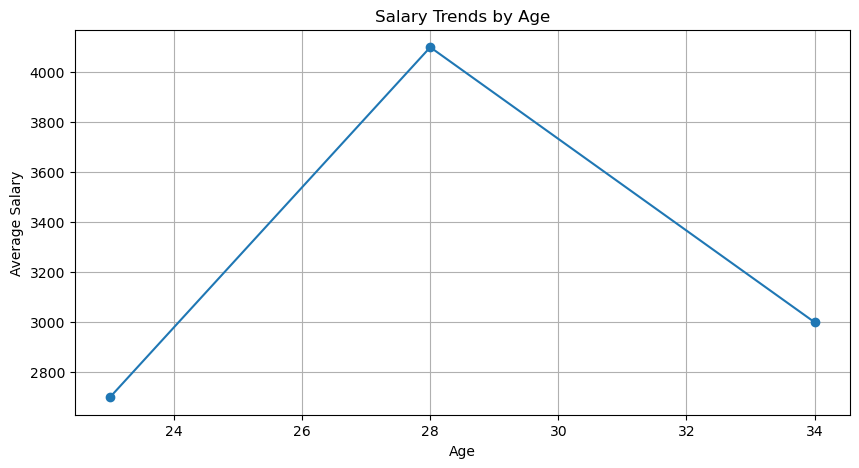

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualization of salary trends
plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()

In [24]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Karyawan15").getOrCreate()

data_karyawan = [
    ('Agus', 'Sales', 25, 4000),
    ('Budi', 'Sales', 28, 4500),
    ('Citra', 'Sales', 30, 5000),
    ('Dewi', 'IT', 24, 5200),
    ('Eko', 'IT', 26, 5500),
    ('Fani', 'IT', 29, 6000),
    ('Gilang', 'Finance', 27, 4800),
    ('Hana', 'Finance', 31, 5300),
    ('Indra', 'Finance', 33, 5700),
    ('Joko', 'Sales', 35, 6200),
    ('Kiki', 'IT', 32, 6400),
    ('Lina', 'Finance', 29, 5100),
    ('Mira', 'Sales', 40, 7000),
    ('Nina', 'IT', 38, 7200),
    ('Oki', 'Finance', 42, 7500)
]

df_karyawan = spark.createDataFrame(data_karyawan, ['Nama', 'Departemen', 'Umur', 'Gaji'])
df_karyawan.createOrReplaceTempView("karyawan")

df_karyawan.show()

+------+----------+----+----+
|  Nama|Departemen|Umur|Gaji|
+------+----------+----+----+
|  Agus|     Sales|  25|4000|
|  Budi|     Sales|  28|4500|
| Citra|     Sales|  30|5000|
|  Dewi|        IT|  24|5200|
|   Eko|        IT|  26|5500|
|  Fani|        IT|  29|6000|
|Gilang|   Finance|  27|4800|
|  Hana|   Finance|  31|5300|
| Indra|   Finance|  33|5700|
|  Joko|     Sales|  35|6200|
|  Kiki|        IT|  32|6400|
|  Lina|   Finance|  29|5100|
|  Mira|     Sales|  40|7000|
|  Nina|        IT|  38|7200|
|   Oki|   Finance|  42|7500|
+------+----------+----+----+



+----------+---------+--------------+
|Departemen|TotalGaji|JumlahKaryawan|
+----------+---------+--------------+
|        IT|    30300|             5|
|   Finance|    28400|             5|
|     Sales|    26700|             5|
+----------+---------+--------------+



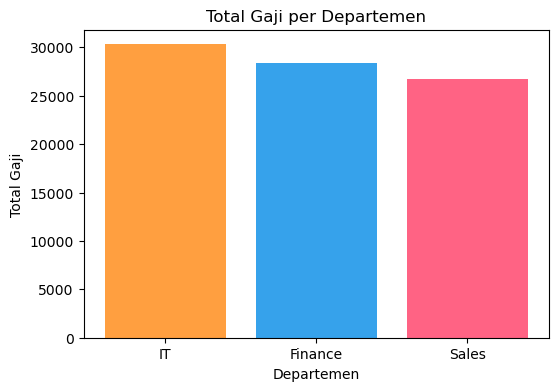

In [25]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

tugas1 = spark.sql('''
SELECT Departemen,
       SUM(Gaji) AS TotalGaji,
       COUNT(Nama) AS JumlahKaryawan
FROM karyawan
GROUP BY Departemen
ORDER BY TotalGaji DESC
''')

tugas1.show()

# Konversi ke Pandas untuk visualisasi
tugas1_pd = tugas1.toPandas()

# Visualisasi perbandingan total gaji antar departemen
plt.figure(figsize=(6,4))
plt.bar(tugas1_pd['Departemen'], tugas1_pd['TotalGaji'], color=['#FF9F40','#36A2EB','#FF6384'])
plt.title('Total Gaji per Departemen')
plt.xlabel('Departemen')
plt.ylabel('Total Gaji')
plt.show()

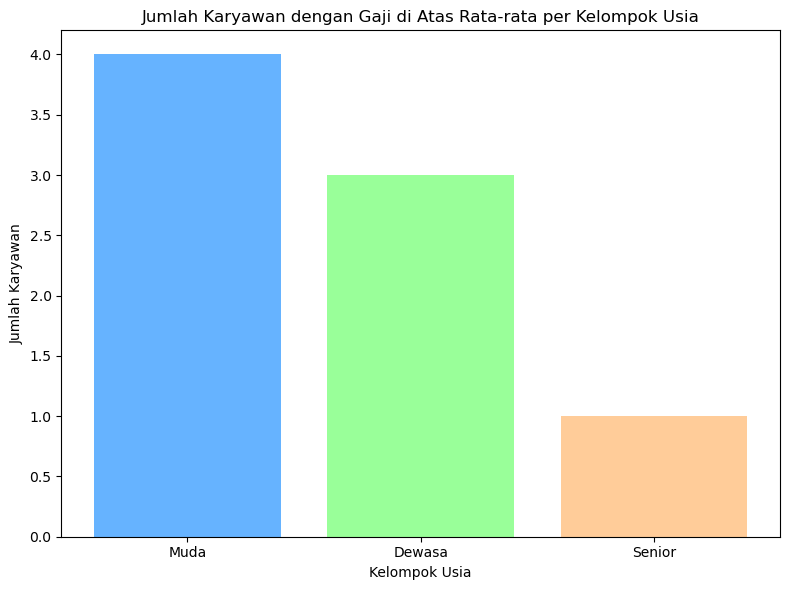

+----+----------+----+----+-------------+
|Nama|Departemen|Umur|Gaji|Kelompok_Usia|
+----+----------+----+----+-------------+
|Dewi|        IT|  24|5200|         Muda|
| Eko|        IT|  26|5500|         Muda|
|Joko|     Sales|  35|6200|       Dewasa|
|Fani|        IT|  29|6000|         Muda|
| Oki|   Finance|  42|7500|       Senior|
|Kiki|        IT|  32|6400|       Dewasa|
|Nina|        IT|  38|7200|       Dewasa|
|Lina|   Finance|  29|5100|         Muda|
+----+----------+----+----+-------------+



In [26]:
from pyspark.sql.functions import avg, col, when
import matplotlib.pyplot as plt

df_kelompok = df_karyawan.withColumn(
    "Kelompok_Usia",
    when(col("Umur") < 30, "Muda")
    .when((col("Umur") >= 30) & (col("Umur") < 40), "Dewasa")
    .otherwise("Senior")
)

rata_gaji = df_kelompok.groupBy("Kelompok_Usia").agg(avg("Gaji").alias("Rata_Rata_Gaji"))

gabung = df_kelompok.join(rata_gaji, on="Kelompok_Usia", how="inner")
above_avg = gabung.filter(col("Gaji") > col("Rata_Rata_Gaji"))

above_avg_pd = above_avg.toPandas()

plt.figure(figsize=(8,6))
counts = above_avg_pd["Kelompok_Usia"].value_counts()
plt.bar(counts.index, counts.values, color=['#66b3ff','#99ff99','#ffcc99'])
plt.title("Jumlah Karyawan dengan Gaji di Atas Rata-rata per Kelompok Usia")
plt.xlabel("Kelompok Usia")
plt.ylabel("Jumlah Karyawan")
plt.tight_layout()
plt.show()

above_avg.select("Nama", "Departemen", "Umur", "Gaji", "Kelompok_Usia").show()

In [18]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Tugas3").getOrCreate()

# Dataset 150 karyawan
data_karyawan = [
# Sales
('Agus1','Sales',25,4000),('Budi2','Sales',26,4200),('Cahyo3','Sales',27,4400),
('Dewi4','Sales',28,4600),('Eka5','Sales',29,4800),('Fajar6','Sales',30,5000),
('Gita7','Sales',31,5200),('Hendra8','Sales',32,5400),('Indah9','Sales',33,5600),
('Joko10','Sales',34,5800),('Kiki11','Sales',35,6000),('Lia12','Sales',36,6200),
('Mira13','Sales',37,6400),('Nina14','Sales',38,6600),('Oki15','Sales',39,6800),
('Putri16','Sales',40,7000),('Rina17','Sales',41,7200),('Sari18','Sales',42,7400),
('Tono19','Sales',43,7600),('Umi20','Sales',44,7800),('Vina21','Sales',45,8000),
('Wawan22','Sales',25,4200),('Xaver23','Sales',26,4400),('Yuni24','Sales',27,4600),
('Zaki25','Sales',28,4800),('Agus26','Sales',29,5000),('Budi27','Sales',30,5200),
('Cahyo28','Sales',31,5400),('Dewi29','Sales',32,5600),('Eka30','Sales',33,5800),

# IT
('Fajar31','IT',25,5000),('Gita32','IT',26,5200),('Hendra33','IT',27,5400),
('Indah34','IT',28,5600),('Joko35','IT',29,5800),('Kiki36','IT',30,6000),
('Lia37','IT',31,6200),('Mira38','IT',32,6400),('Nina39','IT',33,6600),
('Oki40','IT',34,6800),('Putri41','IT',35,7000),('Rina42','IT',36,7200),
('Sari43','IT',37,7400),('Tono44','IT',38,7600),('Umi45','IT',39,7800),
('Vina46','IT',40,8000),('Wawan47','IT',41,8200),('Xaver48','IT',42,8400),
('Yuni49','IT',43,8600),('Zaki50','IT',44,8800),('Agus51','IT',45,9000),
('Budi52','IT',25,5200),('Cahyo53','IT',26,5400),('Dewi54','IT',27,5600),
('Eka55','IT',28,5800),('Fajar56','IT',29,6000),('Gita57','IT',30,6200),
('Hendra58','IT',31,6400),('Indah59','IT',32,6600),('Joko60','IT',33,6800),

# HR
('Kiki61','HR',25,4000),('Lia62','HR',26,4200),('Mira63','HR',27,4400),
('Nina64','HR',28,4600),('Oki65','HR',29,4800),('Putri66','HR',30,5000),
('Rina67','HR',31,5200),('Sari68','HR',32,5400),('Tono69','HR',33,5600),
('Umi70','HR',34,5800),('Vina71','HR',35,6000),('Wawan72','HR',36,6200),
('Xaver73','HR',37,6400),('Yuni74','HR',38,6600),('Zaki75','HR',39,6800),
('Agus76','HR',40,7000),('Budi77','HR',41,7200),('Cahyo78','HR',42,7400),
('Dewi79','HR',43,7600),('Eka80','HR',44,7800),('Fajar81','HR',45,8000),
('Gita82','HR',25,4200),('Hendra83','HR',26,4400),('Indah84','HR',27,4600),
('Joko85','HR',28,4800),('Kiki86','HR',29,5000),('Lia87','HR',30,5200),
('Mira88','HR',31,5400),('Nina89','HR',32,5600),('Oki90','HR',33,5800),

# Finance
('Putri91','Finance',25,5000),('Rina92','Finance',26,5200),('Sari93','Finance',27,5400),
('Tono94','Finance',28,5600),('Umi95','Finance',29,5800),('Vina96','Finance',30,6000),
('Wawan97','Finance',31,6200),('Xaver98','Finance',32,6400),('Yuni99','Finance',33,6600),
('Zaki100','Finance',34,6800),('Agus101','Finance',35,7000),('Budi102','Finance',36,7200),
('Cahyo103','Finance',37,7400),('Dewi104','Finance',38,7600),('Eka105','Finance',39,7800),
('Fajar106','Finance',40,8000),('Gita107','Finance',41,8200),('Hendra108','Finance',42,8400),
('Indah109','Finance',43,8600),('Joko110','Finance',44,8800),('Kiki111','Finance',45,9000),
('Lia112','Finance',25,5200),('Mira113','Finance',26,5400),('Nina114','Finance',27,5600),
('Oki115','Finance',28,5800),('Putri116','Finance',29,6000),('Rina117','Finance',30,6200),
('Sari118','Finance',31,6400),('Tono119','Finance',32,6600),('Umi120','Finance',33,6800),

# Marketing
('Vina121','Marketing',25,4000),('Wawan122','Marketing',26,4200),('Xaver123','Marketing',27,4400),
('Yuni124','Marketing',28,4600),('Zaki125','Marketing',29,4800),('Agus126','Marketing',30,5000),
('Budi127','Marketing',31,5200),('Cahyo128','Marketing',32,5400),('Dewi129','Marketing',33,5600),
('Eka130','Marketing',34,5800),('Fajar131','Marketing',35,6000),('Gita132','Marketing',36,6200),
('Hendra133','Marketing',37,6400),('Indah134','Marketing',38,6600),('Joko135','Marketing',39,6800),
('Kiki136','Marketing',40,7000),('Lia137','Marketing',41,7200),('Mira138','Marketing',42,7400),
('Nina139','Marketing',43,7600),('Oki140','Marketing',44,7800),('Putri141','Marketing',45,8000),
('Rina142','Marketing',25,4200),('Sari143','Marketing',26,4400),('Tono144','Marketing',27,4600),
('Umi145','Marketing',28,4800),('Vina146','Marketing',29,5000),('Wawan147','Marketing',30,5200),
('Xaver148','Marketing',31,5400),('Yuni149','Marketing',32,5600),('Zaki150','Marketing',33,5800)
]

df_karyawan = spark.createDataFrame(data_karyawan, ['Nama','Departemen','Umur','Gaji'])
df_karyawan.createOrReplaceTempView("karyawan")
df_karyawan.show(5)

+------+----------+----+----+
|  Nama|Departemen|Umur|Gaji|
+------+----------+----+----+
| Agus1|     Sales|  25|4000|
| Budi2|     Sales|  26|4200|
|Cahyo3|     Sales|  27|4400|
| Dewi4|     Sales|  28|4600|
|  Eka5|     Sales|  29|4800|
+------+----------+----+----+
only showing top 5 rows



In [10]:
tugas3_1 = spark.sql('''
SELECT Departemen,
       COUNT(*) AS JumlahKaryawan,
       SUM(Gaji) AS TotalGaji,
       AVG(Gaji) AS RataGaji
FROM karyawan
GROUP BY Departemen
ORDER BY RataGaji DESC
''')

tugas3_1.show()

[Stage 84:>                                                         (0 + 3) / 3]

+----------+--------------+---------+--------+
|Departemen|JumlahKaryawan|TotalGaji|RataGaji|
+----------+--------------+---------+--------+
|        IT|            30|   201000|  6700.0|
|   Finance|            30|   201000|  6700.0|
|     Sales|            30|   171000|  5700.0|
|        HR|            30|   171000|  5700.0|
| Marketing|            30|   171000|  5700.0|
+----------+--------------+---------+--------+



In [11]:
tugas3_2 = spark.sql('''
WITH RataPerDept AS (
    SELECT Departemen, AVG(Gaji) AS RataGaji
    FROM karyawan
    GROUP BY Departemen
)
SELECT k.Nama, k.Departemen, k.Gaji, r.RataGaji
FROM karyawan k
JOIN RataPerDept r ON k.Departemen = r.Departemen
WHERE k.Gaji > r.RataGaji
ORDER BY k.Departemen, k.Gaji DESC
''')

tugas3_2.show(10)

+---------+----------+----+--------+
|     Nama|Departemen|Gaji|RataGaji|
+---------+----------+----+--------+
|  Kiki111|   Finance|9000|  6700.0|
|  Joko110|   Finance|8800|  6700.0|
| Indah109|   Finance|8600|  6700.0|
|Hendra108|   Finance|8400|  6700.0|
|  Gita107|   Finance|8200|  6700.0|
| Fajar106|   Finance|8000|  6700.0|
|   Eka105|   Finance|7800|  6700.0|
|  Dewi104|   Finance|7600|  6700.0|
| Cahyo103|   Finance|7400|  6700.0|
|  Budi102|   Finance|7200|  6700.0|
+---------+----------+----+--------+
only showing top 10 rows



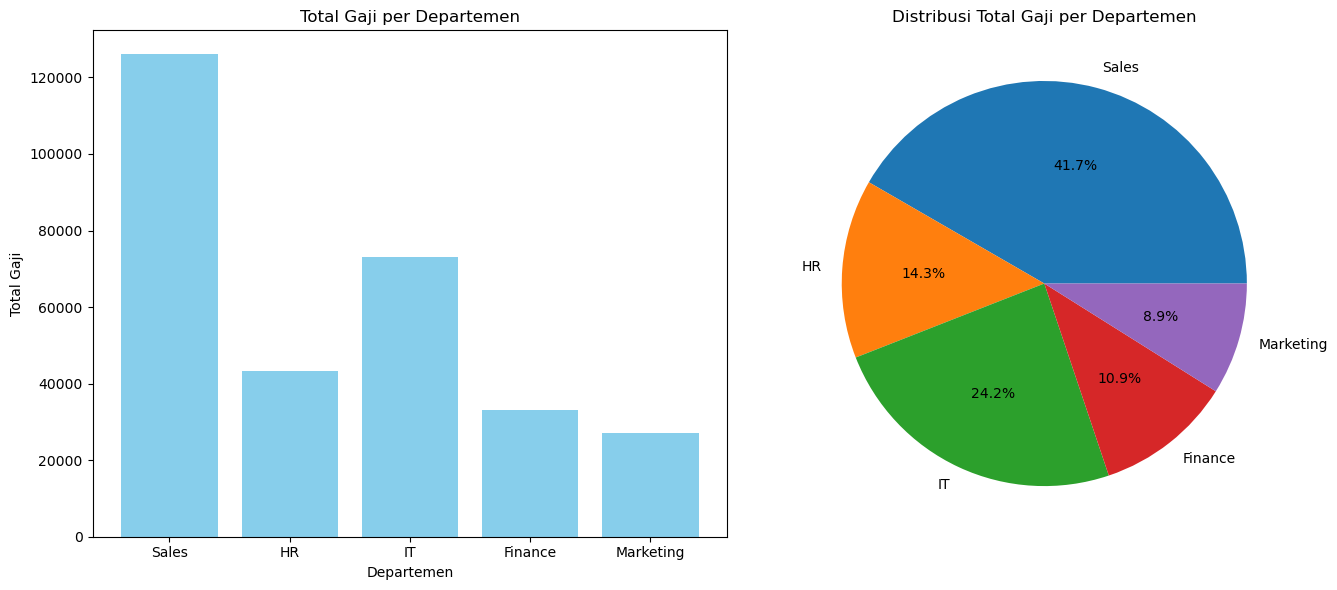

In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, avg
import matplotlib.pyplot as plt
spark = SparkSession.builder.appName("Tugas3").getOrCreate()

data_karyawan = [
('Agus1','Sales',25,4000),('Budi2','Sales',26,4200),('Cahyo3','Sales',27,4400),
('Dewi4','Sales',28,4600),('Eka5','Sales',29,4800),('Fajar6','Sales',30,5000),
('Gita7','Sales',31,5200),('Hendra8','Sales',32,5400),('Indah9','Sales',33,5600),
('Joko10','Sales',34,5800),('Kiki11','Sales',35,6000),('Lia12','Sales',36,6200),
('Mira13','Sales',37,6400),('Nina14','Sales',38,6600),('Oki15','Sales',39,6800),
('Putri16','Sales',40,7000),('Rina17','Sales',41,7200),('Sari18','Sales',42,7400),
('Tono19','Sales',43,7600),('Umi20','Sales',44,7800),('Vina21','Sales',45,8000),

('Fajar31','IT',25,5000),('Gita32','IT',26,5200),('Hendra33','IT',27,5400),
('Indah34','IT',28,5600),('Joko35','IT',29,5800),('Kiki36','IT',30,6000),
('Lia37','IT',31,6200),('Mira38','IT',32,6400),('Nina39','IT',33,6600),
('Oki40','IT',34,6800),('Putri41','IT',35,7000),('Rina42','IT',36,7200),

('Kiki61','HR',25,4000),('Lia62','HR',26,4200),('Mira63','HR',27,4400),
('Nina64','HR',28,4600),('Oki65','HR',29,4800),('Putri66','HR',30,5000),
('Rina67','HR',31,5200),('Sari68','HR',32,5400),('Tono69','HR',33,5600),

('Putri91','Finance',25,5000),('Rina92','Finance',26,5200),('Sari93','Finance',27,5400),
('Tono94','Finance',28,5600),('Umi95','Finance',29,5800),('Vina96','Finance',30,6000),

('Vina121','Marketing',25,4000),('Wawan122','Marketing',26,4200),('Xaver123','Marketing',27,4400),
('Yuni124','Marketing',28,4600),('Zaki125','Marketing',29,4800),('Agus126','Marketing',30,5000)
]

df_karyawan = spark.createDataFrame(data_karyawan, ['Nama','Departemen','Umur','Gaji'])

dept_salary = df_karyawan.groupBy("Departemen").agg(sum("Gaji").alias("Total_Gaji"), avg("Gaji").alias("Rata_Gaji"))

avg_total = df_karyawan.agg(avg("Gaji")).collect()[0][0]
above_avg = dept_salary.filter(dept_salary["Rata_Gaji"] > avg_total)

dept_salary_pd = dept_salary.toPandas()
above_avg_pd = above_avg.toPandas()

fig, axes = plt.subplots(1, 2, figsize=(14,6))

axes[0].bar(dept_salary_pd['Departemen'], dept_salary_pd['Total_Gaji'], color='skyblue')
axes[0].set_title('Total Gaji per Departemen')
axes[0].set_xlabel('Departemen')
axes[0].set_ylabel('Total Gaji')

axes[1].pie(dept_salary_pd['Total_Gaji'], labels=dept_salary_pd['Departemen'], autopct='%1.1f%%')
axes[1].set_title('Distribusi Total Gaji per Departemen')

plt.tight_layout()
plt.show()